In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import modules
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
import os
print(f'current working directory: {os.getcwd()}')

### Data Description
#### train_data:
backgrounds_1: \
backgrounds_2: \
chinese_neg: \
chinese_pos: \
english_neg: \
english_pos: \
logo_col_cn: \
logo_grey_en: \
logo_grey_ru: 

In [ ]:
#生成图片时，需要注意，红色覆盖黑色/黑色覆盖红色，随机，或者重合

In [1]:
from PIL import Image
from utils.image_processing import ImageGenerator
import numpy as np
img = ImageGenerator('/data/Hangyu_Folder/OCR_Project/data/text.bmp')
text_background = img.image
#logo_ = np.array(img.scale_image('logo_1.png', 0.2, (300,500)))

# result = Image.fromarray(w.astype(np.uint8))
# result.save('out.bmp')

In [2]:
from utils.image_manipulation import rotate

In [5]:
img = ImageGenerator('/data/Hangyu_Folder/OCR_Project/data/logo_1.png')
text_background = img.image

In [17]:
import cv2
import math
import numpy as np

def rotate_image(image, angle):
    """
    Rotates an OpenCV 2 / NumPy image about it's centre by the given angle
    (in degrees). The returned image will be large enough to hold the entire
    new image, with a black background
    """

    # Get the image size
    # No that's not an error - NumPy stores image matricies backwards
    image_size = (image.shape[1], image.shape[0])
    image_center = tuple(np.array(image_size) / 2)

    # Convert the OpenCV 3x2 rotation matrix to 3x3
    rot_mat = np.vstack(
        [cv2.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]]
    )

    rot_mat_notranslate = np.matrix(rot_mat[0:2, 0:2])

    # Shorthand for below calcs
    image_w2 = image_size[0] * 0.5
    image_h2 = image_size[1] * 0.5

    # Obtain the rotated coordinates of the image corners
    rotated_coords = [
        (np.array([-image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([-image_w2, -image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2, -image_h2]) * rot_mat_notranslate).A[0]
    ]

    # Find the size of the new image
    x_coords = [pt[0] for pt in rotated_coords]
    x_pos = [x for x in x_coords if x > 0]
    x_neg = [x for x in x_coords if x < 0]

    y_coords = [pt[1] for pt in rotated_coords]
    y_pos = [y for y in y_coords if y > 0]
    y_neg = [y for y in y_coords if y < 0]

    right_bound = max(x_pos)
    left_bound = min(x_neg)
    top_bound = max(y_pos)
    bot_bound = min(y_neg)

    new_w = int(abs(right_bound - left_bound))
    new_h = int(abs(top_bound - bot_bound))

    # We require a translation matrix to keep the image centred
    trans_mat = np.matrix([
        [1, 0, int(new_w * 0.5 - image_w2)],
        [0, 1, int(new_h * 0.5 - image_h2)],
        [0, 0, 1]
    ])

    # Compute the tranform for the combined rotation and translation
    affine_mat = (np.matrix(trans_mat) * np.matrix(rot_mat))[0:2, :]

    # Apply the transform
    result = cv2.warpAffine(
        image,
        affine_mat,
        (new_w, new_h),
        flags=cv2.INTER_LINEAR
    )

    return result


def largest_rotated_rect(w, h, angle):
    """
    Given a rectangle of size wxh that has been rotated by 'angle' (in
    radians), computes the width and height of the largest possible
    axis-aligned rectangle within the rotated rectangle.

    Original JS code by 'Andri' and Magnus Hoff from Stack Overflow

    Converted to Python by Aaron Snoswell
    """

    quadrant = int(math.floor(angle / (math.pi / 2))) & 3
    sign_alpha = angle if ((quadrant & 1) == 0) else math.pi - angle
    alpha = (sign_alpha % math.pi + math.pi) % math.pi

    bb_w = w * math.cos(alpha) + h * math.sin(alpha)
    bb_h = w * math.sin(alpha) + h * math.cos(alpha)

    gamma = math.atan2(bb_w, bb_w) if (w < h) else math.atan2(bb_w, bb_w)

    delta = math.pi - alpha - gamma

    length = h if (w < h) else w

    d = length * math.cos(alpha)
    a = d * math.sin(alpha) / math.sin(delta)

    y = a * math.cos(gamma)
    x = y * math.tan(gamma)

    return (
        bb_w - 2 * x,
        bb_h - 2 * y
    )


def crop_around_center(image, width, height):
    """
    Given a NumPy / OpenCV 2 image, crops it to the given width and height,
    around it's centre point
    """

    image_size = (image.shape[1], image.shape[0])
    image_center = (int(image_size[0] * 0.5), int(image_size[1] * 0.5))

    if(width > image_size[0]):
        width = image_size[0]

    if(height > image_size[1]):
        height = image_size[1]

    x1 = int(image_center[0] - width * 0.5)
    x2 = int(image_center[0] + width * 0.5)
    y1 = int(image_center[1] - height * 0.5)
    y2 = int(image_center[1] + height * 0.5)

    return image[y1:y2, x1:x2]


def demo():
    """
    Demos the largest_rotated_rect function
    """

    image = cv2.imread("/data/Hangyu_Folder/OCR_Project/data/logo_1.png")
    image_height, image_width = image.shape[0:2]


    print("Press [enter] to begin the demo")
    print("Press [q] or Escape to quit")

    key = cv2.waitKey(0)
    if key == ord("q") or key == 27:
        exit()

    for i in np.arange(0, 360, 10):
        image_orig = np.copy(image)
        image_rotated = rotate_image(image, i)
        image_rotated_cropped = crop_around_center(
            image_rotated,
            *largest_rotated_rect(
                image_width,
                image_height,
                math.radians(i)
            )
        )

        key = cv2.waitKey(2)
        if(key == ord("q") or key == 27):
            exit()
    return image_orig, image_rotated, image_rotated_cropped


    print("Done")




Press [enter] to begin the demo
Press [q] or Escape to quit


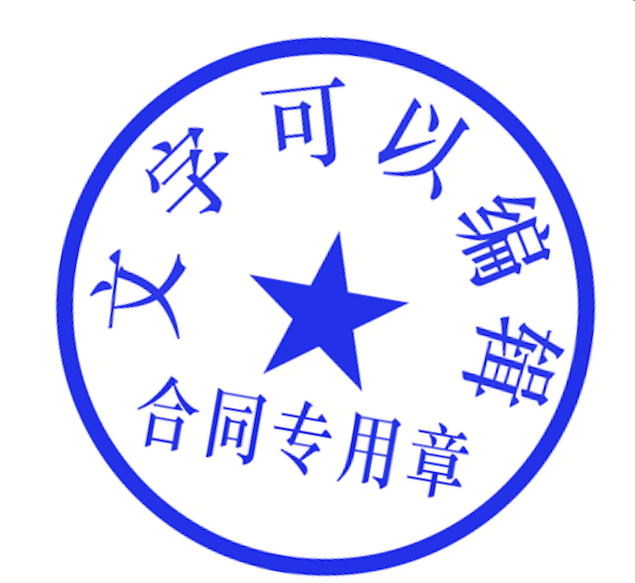

In [19]:
if __name__ == "__main__":
    a,b,c = demo()
from matplotlib import pyplot
from PIL import Image
result = Image.fromarray(c.astype(np.uint8))
result

In [ ]:
result = Image.fromarray((text_background+logo_).astype(np.uint8))
result

In [ ]:
text_background.shape

In [ ]:
test = []
for i in range(1126):
    for j in range(794):
        a = text_background[i,j,:]
        if np.logical_and(a > b, a < c).all():
            test.append(np.array([0,0,0]))
        else:
            test.append(a)

In [ ]:
#########在这里生成训练集和测试集
#x y 

In [ ]:
plt.imshow(np.array(test).reshape(1126,794,3))
plt.axis('off')
ttt = np.array(test).reshape(1126,794,3)
result = Image.fromarray(ttt.astype(np.uint8))

result.save('test.bmp')

In [ ]:
b = np.array([0,0,0])
c = np.array([200,200,200])
d = np.array([254,254,254])

In [ ]:
2682132  / 1126 /794

In [ ]:
t = ((np.array(test).reshape(1126,794,3) + logo_)/2).astype(np.uint8)

In [ ]:
test = []
for i in range(1126):
    for j in range(794):
        a = t[i,j,:]
        if np.logical_and(a > b, a < c).all():
            test.append(np.array([0,0,0]))
        else:
            test.append(a)


In [ ]:
result = Image.fromarray(((np.array(test).reshape(1126,794,3) + logo_)/2).astype(np.uint8))
result

In [ ]:
a = np.array([12,23,23])
b = np.array([11,25,22])
c = np.array([13,25,25])

In [ ]:
np.array([12,23,23]) < np.array([12,24,23]) & 

In [ ]:
logo_hsv=cv2.cvtColor(hc_img, cv2.COLOR_BGR2HSV)
logo_bound = cv2.inRange(logo_hsv, np.array([0,50,50]), np.array([10,255,255])) + cv2.inRange(logo_hsv, np.array([170,50,50]), np.array([180,255,255]))
logo[np.where(logo_bound == 0)] = 255
logo[logo < 255] = 0

#文字部分
text_hsv=cv2.cvtColor(text, cv2.COLOR_BGR2HSV)
text_bound = cv2.inRange(text_hsv, np.array([0,0,0]), np.array([162,162,162]))
text[np.where(text_bound == 0)] = 255
text[text < 255] = 0